In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Things to do next

### Besprechung vom 08.12.2020 
- l1 norm on inner layers of the NN
- sigmoid units on output layer for energy (avoids constraints in MPC)


In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = './data/surrModel_trainingDB_uF0_PS1_ss100k.pkl'
with open(file, 'rb') as f:
    train_data = pickle.load(f)
training_in = train_data['input']
training_out = train_data['output']

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

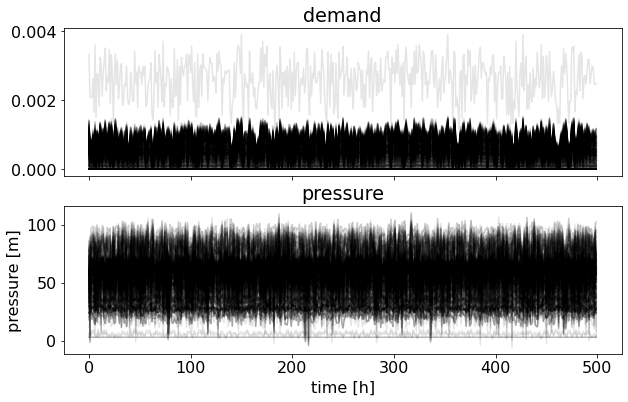

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
#data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
#data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

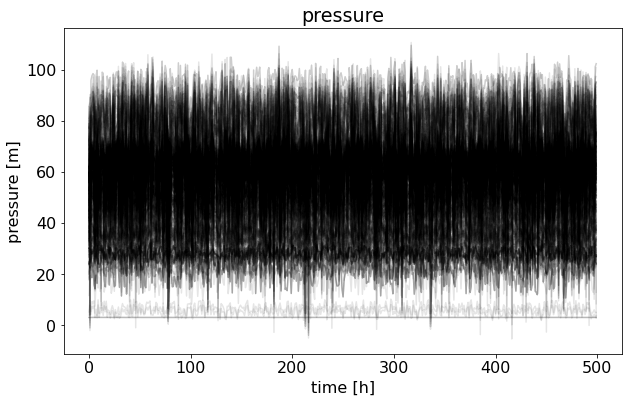

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'next tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

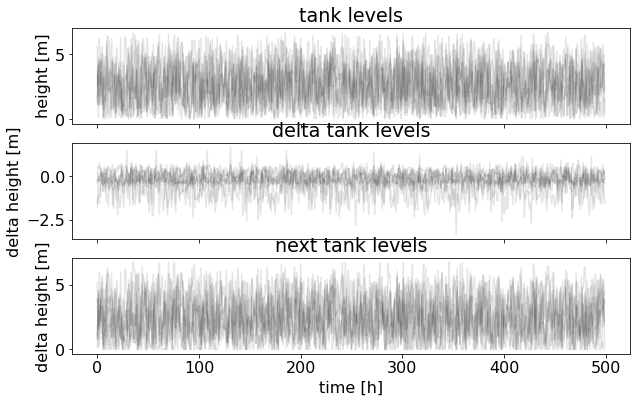

In [11]:
fig, ax = plt.subplots(3,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
dtank_level.columns = tank_level.columns
tank_level_next = tank_level+dtank_level
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')
tank_level_next.head(500).plot(ax=ax[2],legend=False, color='k', alpha=0.1, title='next tank levels', xlabel='time [h]', ylabel='delta height [m]')

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

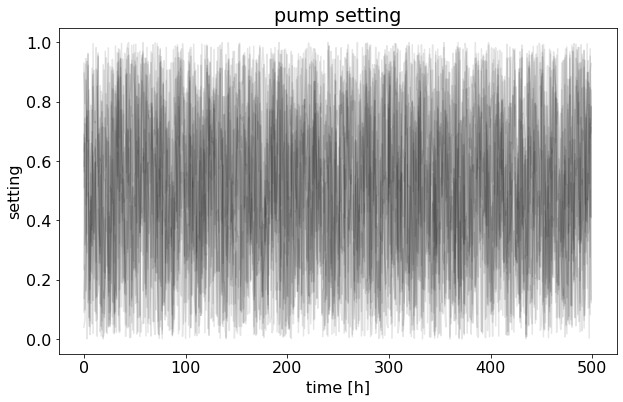

In [14]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

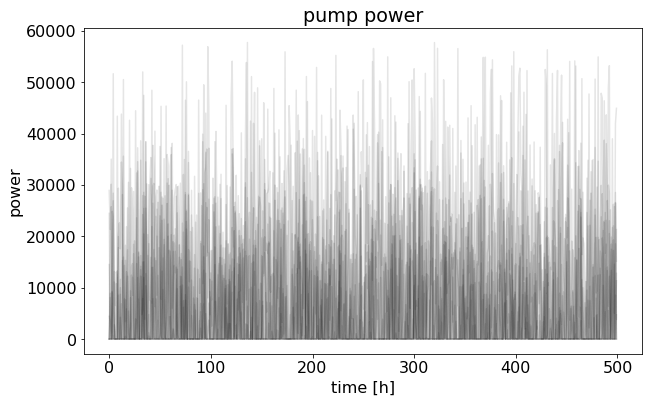

In [15]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [16]:
#data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

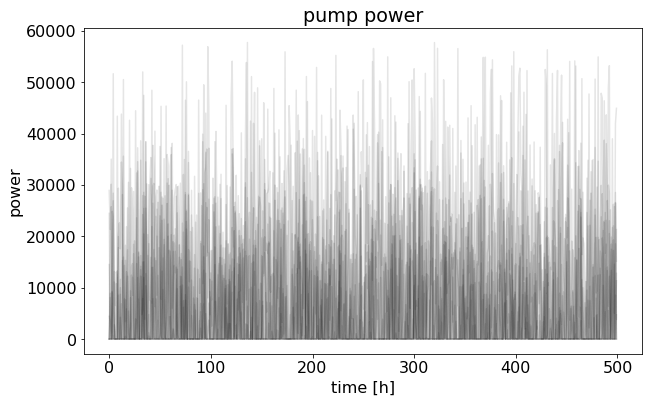

In [17]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

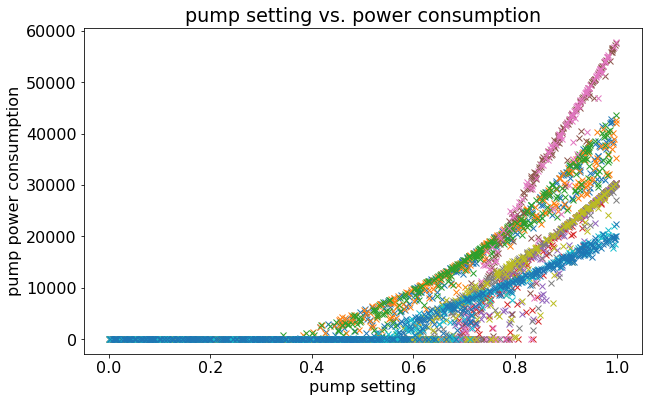

In [18]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

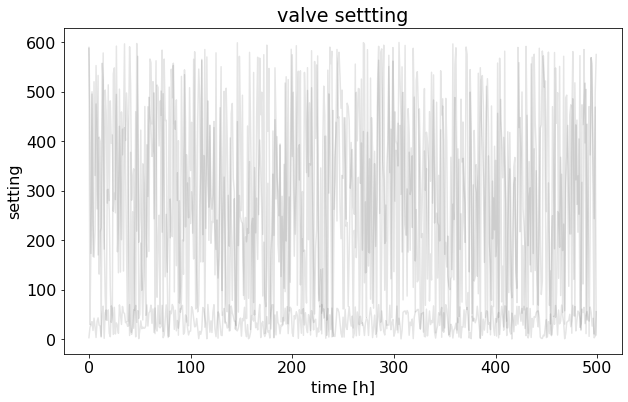

In [19]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [20]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000929  0.000762  0.000828    0.0    0.0  0.001107    0.0    0.0   
1        0.000587  0.000412  0.000447    0.0    0.0  0.000598    0.0    0.0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.001048  0.000913  ...     0.234480  0.040475  0.511187  0.564586   
1  0.000725  0.000631  ...     0.725745  0.064877  0.660430  0.889907   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.929807  0.583212  0.632190    589.815644  587.652053   2.766015  
1  0.098324  0.745180  0.679041    449.815104   29.166241  23.221929  

[2 rows x 409 columns]

### NN outputs:

In [21]:
output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'tank_level': dtank_level[data_filter],
    #'tank_level': tank_level_next[data_filter]
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         28.516209  63.541023  36.594948  58.643337  81.043335  33.113400   
1         31.023098  65.504532  38.143955  66.849159  89.249161  34.497074   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  32.755207  29.097137  48.912586  44.836769  ...  24463.834489     0.000000   
1  32.570992  28.920317  54.977676  50.884941  ...      0.000000  8904.443241   

                  dstates                                                    \
               tank_level                                                     
        PU11_P         T3        T1        T7        T6        T5        T2   
0  4406.649493  -0.414477 -0.194584 -1.587196 -0.258440  0.167841  0.520759   
1  3395.104302   0.031338 -0.311106 -0.220377  0.170594  0.423695  0.488421   

             
             
         T4  
0 -1.789435  
1 -1.130805  

[2 rows x 406 columns]

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [22]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=100000, n_inputs = 409, n_outputs=406


Split into test and train set:

In [23]:
nn_input_train, nn_input_test, nn_output_train, nn_output_test = train_test_split(
    nn_input, nn_output, test_size = 0.1
)

In [24]:
input_scaling = nn_input_train.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_train_scaled = nn_input_train/input_scaling
nn_input_test_scaled = nn_input_test/input_scaling

output_scaling = nn_output_train.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_train_scaled = nn_output_train/output_scaling
nn_output_test_scaled = nn_output_test/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [37]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
unitnorm_cons = tf.keras.constraints.UnitNorm(
    axis=1
)

l1_penalty = tf.keras.regularizers.l1(l=0.0001)
l2_penalty = tf.keras.regularizers.l2(l=0.01)

In [204]:
n_cluster = 30
n_layer = 4
n_neurons_per_layer = 51

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')

tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=True,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

tf_in_2_scaled = tf_in_2/input_scaling['states']
tf_in_3_scaled = tf_in_3/input_scaling['inputs']

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
tf_interm_a = tf_in_cat
for i in range(n_layer):
    kernel_regularizer = None
    kernel_constraint = None #tf.keras.constraints.MaxNorm(max_value=1, axis=[0,1])
    
    tf_interm_b = tf.keras.layers.Dense(
        n_neurons_per_layer, 
        activation=tf.nn.tanh, 
        kernel_regularizer = kernel_regularizer,
        kernel_constraint = kernel_constraint,
        name='interm_'+str(i)
    )(tf_interm_a)
        
    tf_interm_a = tf_interm_b
    

# splitting:
tf_interm_1 = tf_interm_a[:,:n_cluster]
tf_interm_2 = tf_interm_a[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    kernel_constraint=nonneg_cons,
    #kernel_constraint = unitnorm_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)


tf_out_3 = tf.keras.layers.Dense(
    nn_output['dstates'].shape[1], 
    name='dstates_out',
)(tf_interm_2)

tf_out_3 = tf.keras.layers.add([tf_out_3, tf_in_2], name='states_out')

In [205]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [206]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [207]:
x_subset = nn_input_train_scaled.head(20000)
y_subset = nn_output_train_scaled.head(20000)

x_train = [x_subset['demand'], x_subset['states'], x_subset['inputs']]
y_train = [y_subset['pressure'], y_subset['energy'], y_subset['dstates']]
x_test = [nn_input_test_scaled['demand'], nn_input_test_scaled['states'], nn_input_test_scaled['inputs']]
y_test = [nn_output_test_scaled['pressure'], nn_output_test_scaled['energy'], nn_output_test_scaled['dstates']]

history = model.fit(x_train, y_train,
                    batch_size=5000, 
                    epochs=1500)

Epoch 1/1500
4/4 [==============================] - 0s 27ms/step - loss: 1.4080 - pressure_out_loss: 0.6318 - energy_out_loss: 0.2314 - states_out_loss: 0.5449
Epoch 2/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.7279 - pressure_out_loss: 0.3082 - energy_out_loss: 0.1487 - states_out_loss: 0.2710
Epoch 3/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.4754 - pressure_out_loss: 0.1384 - energy_out_loss: 0.1017 - states_out_loss: 0.2353
Epoch 4/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.3734 - pressure_out_loss: 0.0594 - energy_out_loss: 0.0874 - states_out_loss: 0.2266
Epoch 5/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.3303 - pressure_out_loss: 0.0327 - energy_out_loss: 0.0775 - states_out_loss: 0.2202
Epoch 6/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.3147 - pressure_out_loss: 0.0263 - energy_out_loss: 0.0753 - states_out_loss: 0.2130
Epoch 7/1500
4/4 [======================

4/4 [==============================] - 0s 27ms/step - loss: 0.0644 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0279 - states_out_loss: 0.0326
Epoch 102/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0641 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0276 - states_out_loss: 0.0326
Epoch 103/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0639 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0274 - states_out_loss: 0.0327
Epoch 104/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0636 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0271 - states_out_loss: 0.0326
Epoch 105/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0632 - pressure_out_loss: 0.0039 - energy_out_loss: 0.0269 - states_out_loss: 0.0325
Epoch 106/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0628 - pressure_out_loss: 0.0038 - energy_out_loss: 0.0267 - states_out_loss: 0.0323
Epoch 107/1500
4/4 [=======================

4/4 [==============================] - 0s 27ms/step - loss: 0.0558 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0315
Epoch 202/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0557 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0314
Epoch 203/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0557 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0314
Epoch 204/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0559 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0315
Epoch 205/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0561 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0317
Epoch 206/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0560 - pressure_out_loss: 0.0033 - energy_out_loss: 0.0211 - states_out_loss: 0.0317
Epoch 207/1500
4/4 [=======================

4/4 [==============================] - 0s 26ms/step - loss: 0.0541 - pressure_out_loss: 0.0029 - energy_out_loss: 0.0206 - states_out_loss: 0.0306
Epoch 302/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0541 - pressure_out_loss: 0.0029 - energy_out_loss: 0.0206 - states_out_loss: 0.0306
Epoch 303/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0543 - pressure_out_loss: 0.0029 - energy_out_loss: 0.0207 - states_out_loss: 0.0307
Epoch 304/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0541 - pressure_out_loss: 0.0028 - energy_out_loss: 0.0206 - states_out_loss: 0.0306
Epoch 305/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0546 - pressure_out_loss: 0.0028 - energy_out_loss: 0.0207 - states_out_loss: 0.0311
Epoch 306/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0546 - pressure_out_loss: 0.0028 - energy_out_loss: 0.0207 - states_out_loss: 0.0311
Epoch 307/1500
4/4 [=======================

4/4 [==============================] - 0s 26ms/step - loss: 0.0526 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0297
Epoch 402/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0528 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0299
Epoch 403/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0527 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0298
Epoch 404/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0526 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0298
Epoch 405/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0529 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0300
Epoch 406/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0528 - pressure_out_loss: 0.0025 - energy_out_loss: 0.0203 - states_out_loss: 0.0300
Epoch 407/1500
4/4 [=======================

4/4 [==============================] - 0s 27ms/step - loss: 0.0500 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0194 - states_out_loss: 0.0282
Epoch 502/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0495 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0193 - states_out_loss: 0.0278
Epoch 503/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0494 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0193 - states_out_loss: 0.0278
Epoch 504/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0493 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0193 - states_out_loss: 0.0276
Epoch 505/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0492 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0193 - states_out_loss: 0.0276
Epoch 506/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0492 - pressure_out_loss: 0.0024 - energy_out_loss: 0.0193 - states_out_loss: 0.0276
Epoch 507/1500
4/4 [=======================

4/4 [==============================] - 0s 28ms/step - loss: 0.0452 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0255
Epoch 602/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0452 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0255
Epoch 603/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0453 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0256
Epoch 604/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0459 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0262
Epoch 605/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0456 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0259
Epoch 606/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0455 - pressure_out_loss: 0.0022 - energy_out_loss: 0.0175 - states_out_loss: 0.0258
Epoch 607/1500
4/4 [=======================

4/4 [==============================] - 0s 26ms/step - loss: 0.0411 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0156 - states_out_loss: 0.0234
Epoch 702/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0409 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0156 - states_out_loss: 0.0232
Epoch 703/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0413 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0156 - states_out_loss: 0.0235
Epoch 704/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0413 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0156 - states_out_loss: 0.0235
Epoch 705/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0414 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0156 - states_out_loss: 0.0236
Epoch 706/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0419 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0157 - states_out_loss: 0.0241
Epoch 707/1500
4/4 [=======================

4/4 [==============================] - 0s 27ms/step - loss: 0.0356 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0127 - states_out_loss: 0.0209
Epoch 802/1500
4/4 [==============================] - 0s 25ms/step - loss: 0.0363 - pressure_out_loss: 0.0021 - energy_out_loss: 0.0128 - states_out_loss: 0.0214
Epoch 803/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0356 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0126 - states_out_loss: 0.0210
Epoch 804/1500
4/4 [==============================] - 0s 25ms/step - loss: 0.0356 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0126 - states_out_loss: 0.0209
Epoch 805/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0352 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0125 - states_out_loss: 0.0207
Epoch 806/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0351 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0124 - states_out_loss: 0.0206
Epoch 807/1500
4/4 [=======================

4/4 [==============================] - 0s 26ms/step - loss: 0.0299 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0090 - states_out_loss: 0.0190
Epoch 902/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0293 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0088 - states_out_loss: 0.0185
Epoch 903/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0292 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0088 - states_out_loss: 0.0185
Epoch 904/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0290 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0087 - states_out_loss: 0.0183
Epoch 905/1500
4/4 [==============================] - 0s 25ms/step - loss: 0.0289 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0086 - states_out_loss: 0.0183
Epoch 906/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0289 - pressure_out_loss: 0.0020 - energy_out_loss: 0.0086 - states_out_loss: 0.0183
Epoch 907/1500
4/4 [=======================

4/4 [==============================] - 0s 27ms/step - loss: 0.0245 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0063 - states_out_loss: 0.0163
Epoch 1002/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0244 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0063 - states_out_loss: 0.0162
Epoch 1003/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0248 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0063 - states_out_loss: 0.0167
Epoch 1004/1500
4/4 [==============================] - 0s 25ms/step - loss: 0.0248 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0063 - states_out_loss: 0.0167
Epoch 1005/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0252 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0063 - states_out_loss: 0.0171
Epoch 1006/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0245 - pressure_out_loss: 0.0019 - energy_out_loss: 0.0062 - states_out_loss: 0.0164
Epoch 1007/1500
4/4 [=================

4/4 [==============================] - 0s 27ms/step - loss: 0.0212 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0051 - states_out_loss: 0.0142
Epoch 1102/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0211 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0051 - states_out_loss: 0.0142
Epoch 1103/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0216 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0052 - states_out_loss: 0.0147
Epoch 1104/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0215 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0051 - states_out_loss: 0.0146
Epoch 1105/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0215 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0052 - states_out_loss: 0.0145
Epoch 1106/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0210 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0051 - states_out_loss: 0.0142
Epoch 1107/1500
4/4 [=================

4/4 [==============================] - 0s 25ms/step - loss: 0.0189 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0040 - states_out_loss: 0.0131
Epoch 1202/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0186 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0040 - states_out_loss: 0.0129
Epoch 1203/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0188 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0041 - states_out_loss: 0.0130
Epoch 1204/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0191 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0041 - states_out_loss: 0.0131
Epoch 1205/1500
4/4 [==============================] - 0s 25ms/step - loss: 0.0189 - pressure_out_loss: 0.0018 - energy_out_loss: 0.0041 - states_out_loss: 0.0130
Epoch 1206/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0185 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0040 - states_out_loss: 0.0128
Epoch 1207/1500
4/4 [=================

4/4 [==============================] - 0s 30ms/step - loss: 0.0181 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0035 - states_out_loss: 0.0129
Epoch 1302/1500
4/4 [==============================] - 0s 30ms/step - loss: 0.0173 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0032 - states_out_loss: 0.0124
Epoch 1303/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0178 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0034 - states_out_loss: 0.0127
Epoch 1304/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0177 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0033 - states_out_loss: 0.0127
Epoch 1305/1500
4/4 [==============================] - 0s 30ms/step - loss: 0.0172 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0032 - states_out_loss: 0.0123
Epoch 1306/1500
4/4 [==============================] - 0s 29ms/step - loss: 0.0169 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0032 - states_out_loss: 0.0120
Epoch 1307/1500
4/4 [=================

4/4 [==============================] - 0s 28ms/step - loss: 0.0157 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0113
Epoch 1402/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0154 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0110
Epoch 1403/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0154 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0110
Epoch 1404/1500
4/4 [==============================] - 0s 26ms/step - loss: 0.0154 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0110
Epoch 1405/1500
4/4 [==============================] - 0s 27ms/step - loss: 0.0159 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0115
Epoch 1406/1500
4/4 [==============================] - 0s 28ms/step - loss: 0.0154 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0027 - states_out_loss: 0.0110
Epoch 1407/1500
4/4 [=================

In [208]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 724us/step - loss: 0.0143 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0024 - states_out_loss: 0.0102


[0.014260784722864628,
 0.0015776903601363301,
 0.0024497562553733587,
 0.010233337059617043]

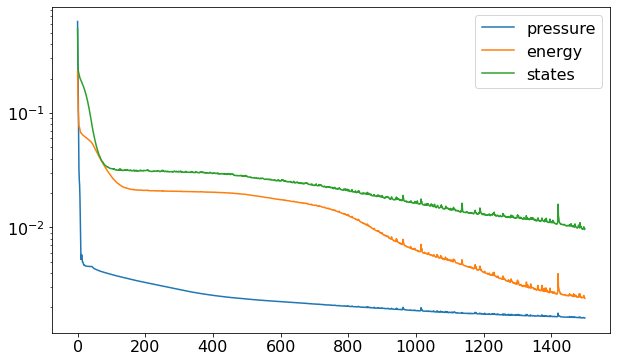

In [209]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['states_out_loss'], label='states')
plt.legend()

In [210]:
A_cluster = model.get_layer('pressure_out').get_weights()[0]

In [211]:
np.sum(np.abs(A_cluster)<1e-6)

540

In [212]:
np.prod(A_cluster.shape)

11640

# Validation data

In [213]:
file = './validation/surrModel_scenarioDB_ruleBased_altControl2.pkl'
with open(file, 'rb') as f:
    validation = pickle.load(f)

In [214]:
output_names.keys()

dict_keys(['pressure', 'tanks', 'power'])

In [215]:
val_demand = validation['input'][input_names['demand']]
val_states = validation['input'][input_names['tanks']]
val_inputs = validation['input'][input_names['pumps']+input_names['valves']]

val_pressure = validation['output'][output_names['pressure']]
val_energy = validation['output'][output_names['power']]

<AxesSubplot:>

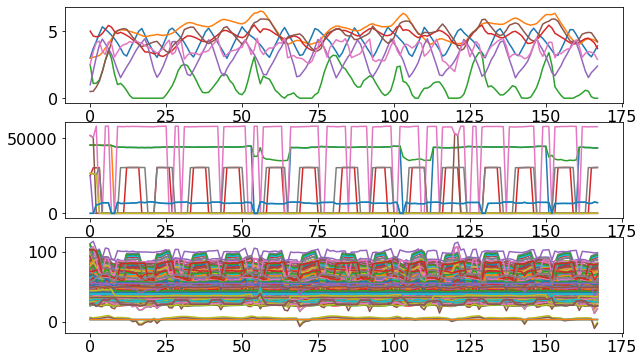

In [216]:
fig,ax = plt.subplots(3,1)
val_states.plot(ax=ax[0], legend=False)
val_energy.plot(ax=ax[1], legend=False)
val_pressure.plot(ax=ax[2], legend=False)

Text(0, 0.5, 'pump power ')

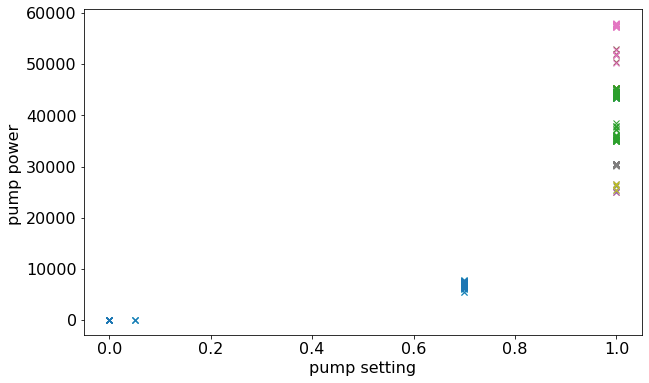

In [217]:
fig, ax = plt.subplots()
ax.plot(
    val_inputs[input_names['pumps']],
    val_energy[output_names['power']],
    'x'
)
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power ')

### Simulation evaluation

In [218]:
from IPython.display import clear_output, display

In [219]:
val_demand_np = val_demand.to_numpy()
val_states_np = val_states.to_numpy()
val_inputs_np = val_inputs.to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

Open loop simulation of the Neural Network

In [220]:
est_states = [val_states_np[[0]]]
est_pressure = []
est_energy = []

for k in range(val_inputs_np.shape[0]-1):
    clear_output(wait=True)
    print(k)
    demand_k = val_demand_np[[k],:]
    states_k = est_states[k]
    inputs_k = val_inputs_np[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    #states_k_next = dstates_scaled * out_s_scaling
    
    ### Achtung ENTFERNEN!!!!!!
    #states_k_next = val_states_np[[k+1]]
    states_k_next = np.minimum(np.maximum(states_k_next,0),6)
    
    est_states.append(states_k_next)
    est_energy.append(energy_k)
    est_pressure.append(pressure_k)

est_pressure = np.concatenate(est_pressure,axis=0)
est_energy = np.concatenate(est_energy,axis=0)
est_states = np.concatenate(est_states,axis=0)

est_pressure_df = pd.DataFrame(data=est_pressure, index=val_pressure.index[:-1], columns=val_pressure.keys())
est_energy_df = pd.DataFrame(data=est_energy, index=val_energy.index[:-1], columns=val_energy.keys())
est_states_df = pd.DataFrame(data=est_states, index=val_states.index, columns=val_states.keys())

166


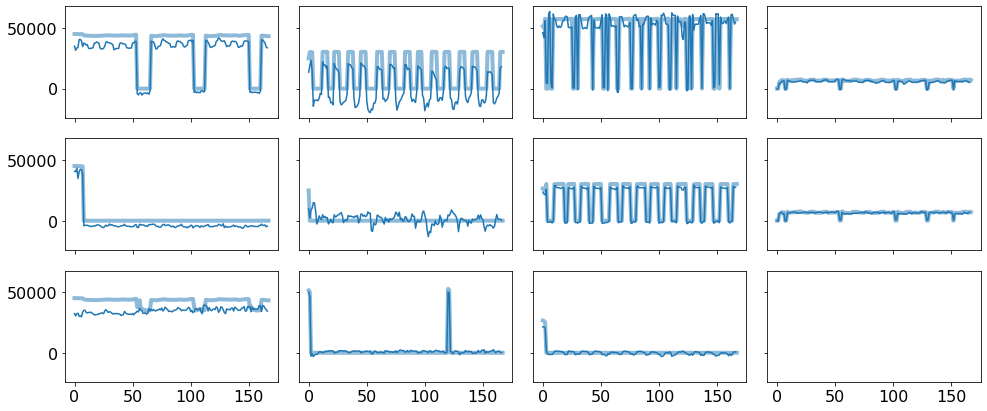

In [221]:
fig,ax = plt.subplots(3,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_energy.keys()):
    i,j = k%3,k//3
    
    val_energy[name].plot(legend=False, ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_energy_df[name].plot(legend=False, ax=ax[i,j])

fig.tight_layout()
    

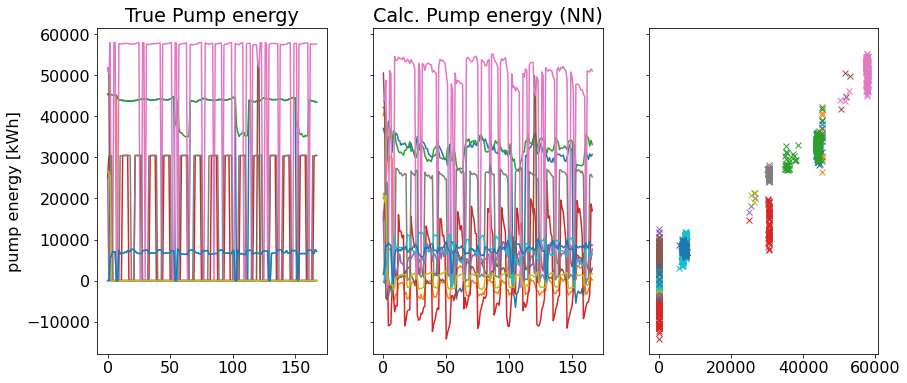

In [190]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_energy.plot(legend=False, ax=ax[0])
ax[1].plot(est_energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')

ax[2].plot(val_energy.to_numpy()[:-1,:], est_energy, 'x')

plt.show()

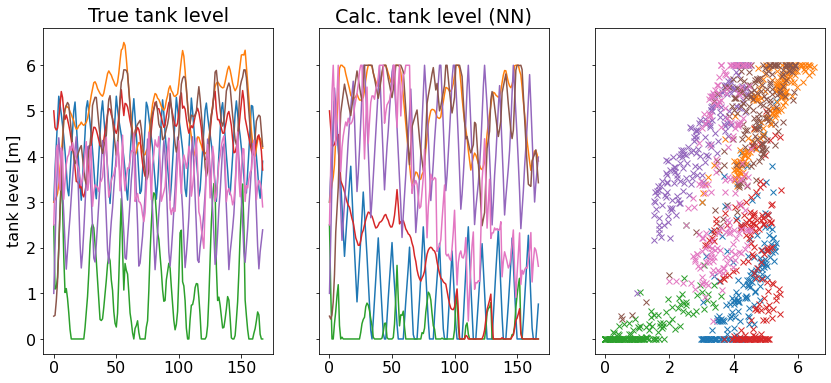

In [222]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.plot(legend=False, ax=ax[0])
ax[1].plot(est_states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states,est_states,'x')



plt.show()

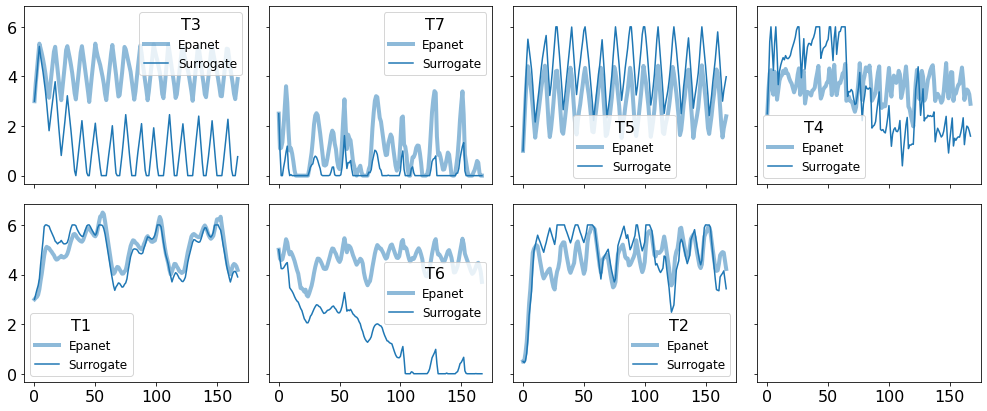

In [223]:
fig,ax = plt.subplots(2,4, figsize=(14,6), sharey=True, sharex=True)

for k,name in enumerate(val_states.keys()):
    i,j = k%2,k//2
    
    val_states[name].plot(ax=ax[i,j],linewidth=4, alpha=.5)
    ax[i,j].set_prop_cycle(None)
    est_states_df[name].plot(ax=ax[i,j])
    ax[i,j].legend(ax[i,j].lines,['Epanet','Surrogate'], title=name, fontsize=12)

fig.tight_layout()

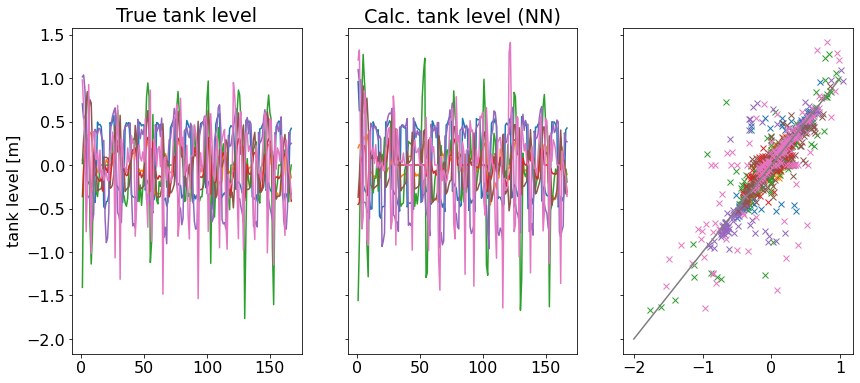

In [193]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_states.diff().plot(legend=False, ax=ax[0])
est_states_df.diff().plot(legend=False, ax=ax[1])
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')

ax[2].plot(val_states.diff(), est_states_df.diff(),'x')
ax[2].plot([-2,1],[-2,1])

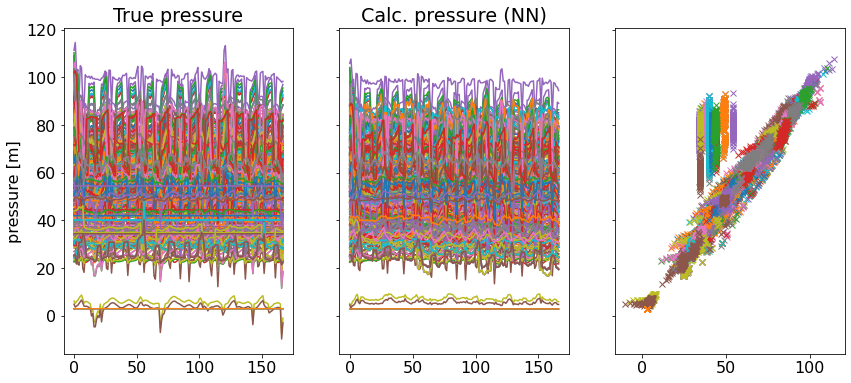

In [194]:
fig,ax = plt.subplots(1,3, figsize=(14,6), sharey=True)
val_pressure.plot(legend=False, ax=ax[0])
ax[1].plot(est_pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
ax[2].plot(val_pressure.to_numpy()[:-1,:],est_pressure, 'x')
plt.show()

Should we save the model?

In [82]:
model_name = '004'
model.save('./keras_models/{name}/{name}_model'.format(name=model_name))
scaling = {
    'input': input_scaling,
    'output': output_scaling
}

with open('./keras_models/{}/scaling.pkl'.format(model_name), 'wb') as f:
    pickle.dump(scaling, f)
    
history_export = history.history
history_export['epoch'] = history.epoch

with open('./keras_models/{}/history.pkl'.format(model_name), 'wb') as f:
    pickle.dump(history_export, f)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./keras_models/004/004_model/assets
